# Practical session n°4

Notions:
- Semantic segmentation
- Intersection over Union
- Image Denoising
- Fully convolutional networks, U-Net
- Weak supervision (in part II): The noise-to-noise and the Neural Eggs Separation scenarios.

Duration: 2 h + 2 h

In P3, we illustrated how Convolutional Neural Networks (CNNs) are trained for image classification tasks. In this practical session, we demonstrate how to achieve pixel-level predictions for tasks like semantic segmentation and image denoising.

To start, we’ll simply apply an off-the-shelf model. Then, we’ll focus on training a model from scratch (part I, exercise 2 and part II).

In P3, we also introduced a crucial set of methods known as "transfer learning," which is particularly effective when there’s limited training data. In this session, we’ll explore another equally important set of methods called "weak supervision," which is well-suited for cases where ground truth is imperfectly known (Part II).

## Part II: denoising with FCN - weakly-supervised approaches




In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [6]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P4/utile.py .
from utile import gen_noise2noise, voir_batch2D, UNet

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


###**Exercise 1: The "noise to noise" scenario**

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The *gen_noise2noise* function allows us to sample from both datasets:

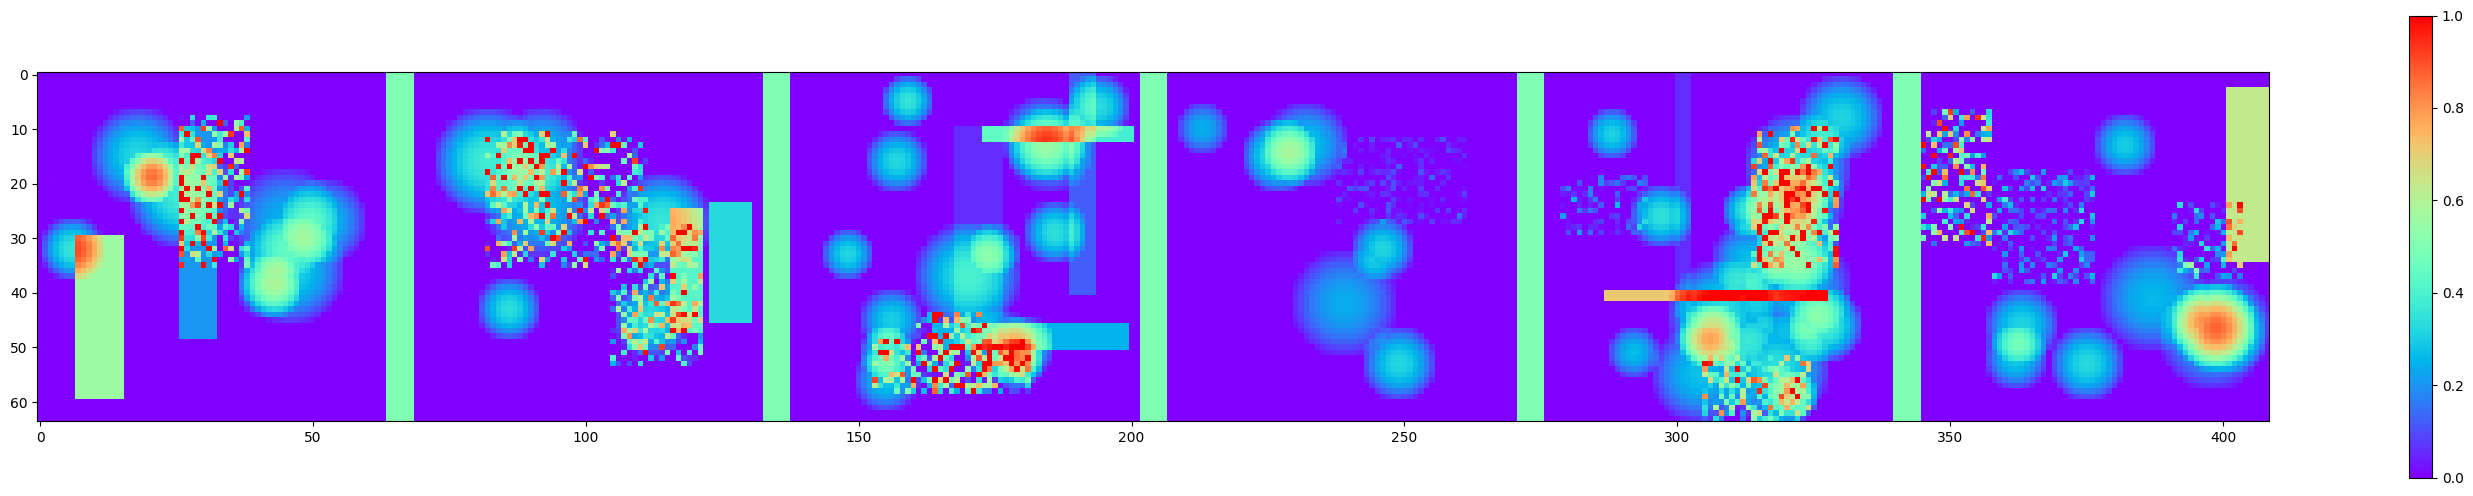

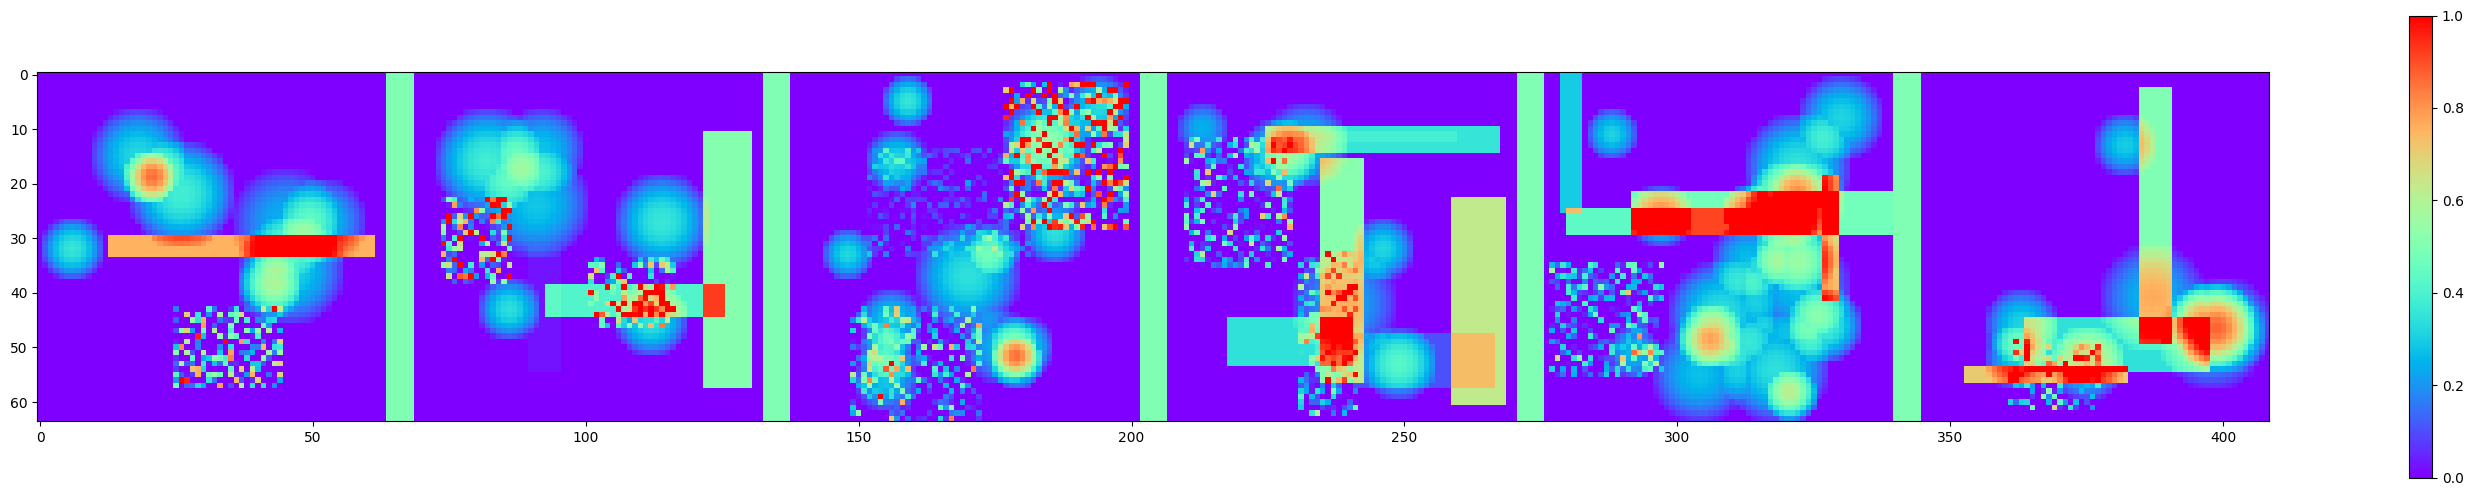

In [7]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Define a learning procedure that effectively denoises the image.

In [ ]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [ ]:
nepochs = 40
nbatches = 100
batchsize = 64
train_losses = []

fcn = fcn.cuda()

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")

    epoch_losses = []
    for batch in range(nbatches):
        # we consider the image1 as input and the image2 as the target
        image1, image2 = gen_noise2noise(batchsize)

        image1 = image1.cuda()
        image2 = image2.cuda()

        optimizer.zero_grad()

        output = fcn(image1)

        loss = F.mse_loss(output, image2)

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

Epoch 1/40
Epoch loss: 0.0458
Epoch 2/40
Epoch loss: 0.0456
Epoch 3/40
Epoch loss: 0.0454
Epoch 4/40
Epoch loss: 0.0455
Epoch 5/40
Epoch loss: 0.0451
Epoch 6/40
Epoch loss: 0.0454
Epoch 7/40
Epoch loss: 0.0451
Epoch 8/40
Epoch loss: 0.0451
Epoch 9/40
Epoch loss: 0.0450
Epoch 10/40
Epoch loss: 0.0443
Epoch 11/40
Epoch loss: 0.0445
Epoch 12/40
Epoch loss: 0.0441
Epoch 13/40
Epoch loss: 0.0446
Epoch 14/40
Epoch loss: 0.0443
Epoch 15/40
Epoch loss: 0.0440
Epoch 16/40
Epoch loss: 0.0448
Epoch 17/40
Epoch loss: 0.0446
Epoch 18/40
Epoch loss: 0.0443
Epoch 19/40
Epoch loss: 0.0444
Epoch 20/40
Epoch loss: 0.0441
Epoch 21/40
Epoch loss: 0.0441
Epoch 22/40
Epoch loss: 0.0437
Epoch 23/40
Epoch loss: 0.0442
Epoch 24/40
Epoch loss: 0.0444
Epoch 25/40
Epoch loss: 0.0447
Epoch 26/40
Epoch loss: 0.0448
Epoch 27/40
Epoch loss: 0.0436
Epoch 28/40
Epoch loss: 0.0448
Epoch 29/40
Epoch loss: 0.0440
Epoch 30/40
Epoch loss: 0.0442
Epoch 31/40
Epoch loss: 0.0449
Epoch 32/40
Epoch loss: 0.0442
Epoch 33/40
Epoch

In [3]:
# viz:
fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs


NameError: name 'fcn' is not defined

**Q2:** Theoretical analysis:

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite $\mathbb{E}_{(X,Y)}[ \mathcal{L} (f_\theta(X), Y) ]$ to justify the approach taken for **Q1**.



...


###**Exercise 2: The "NES" scenario (Neural Egg Separation)**

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).   



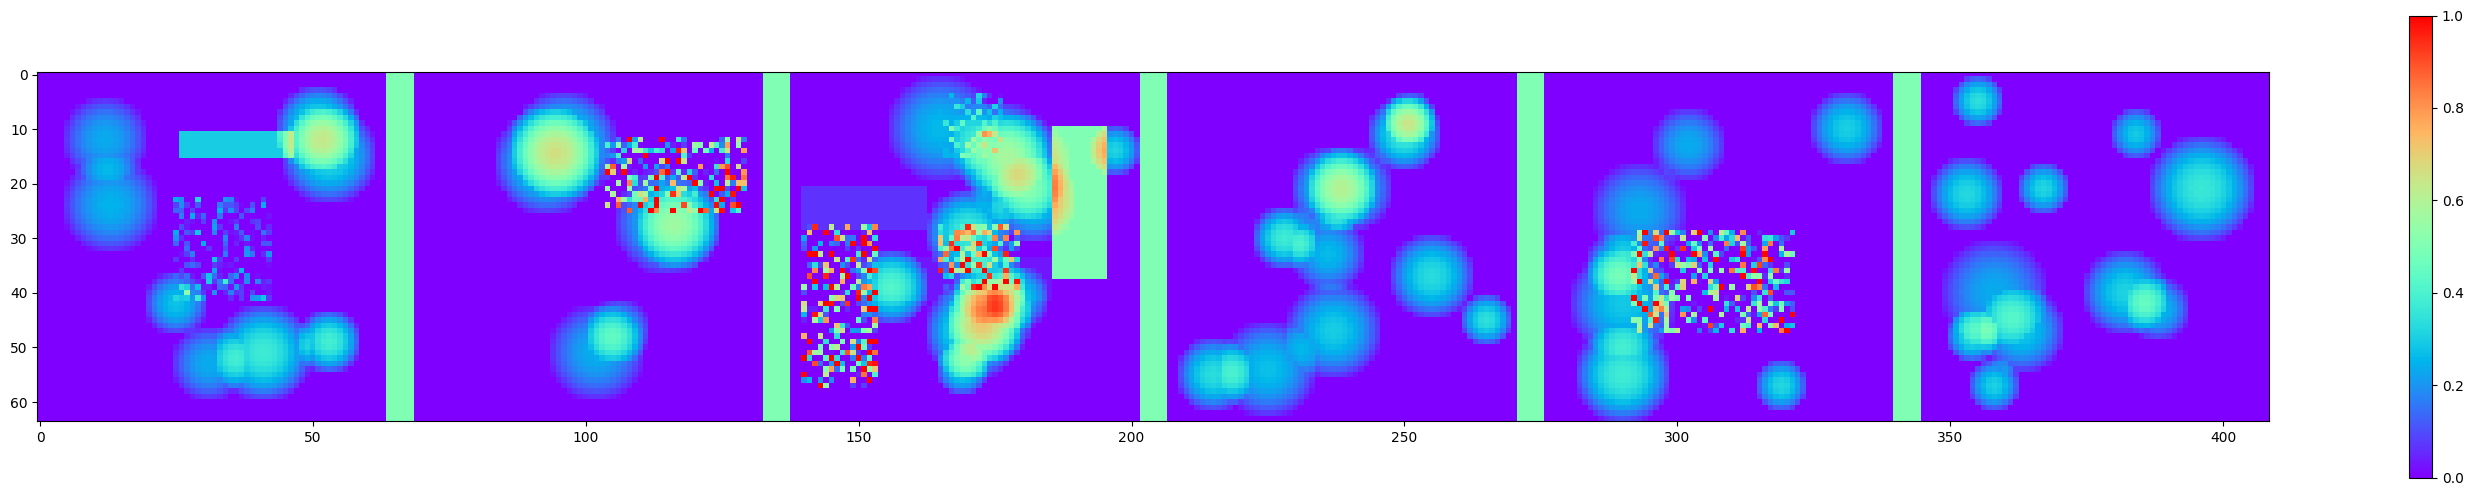

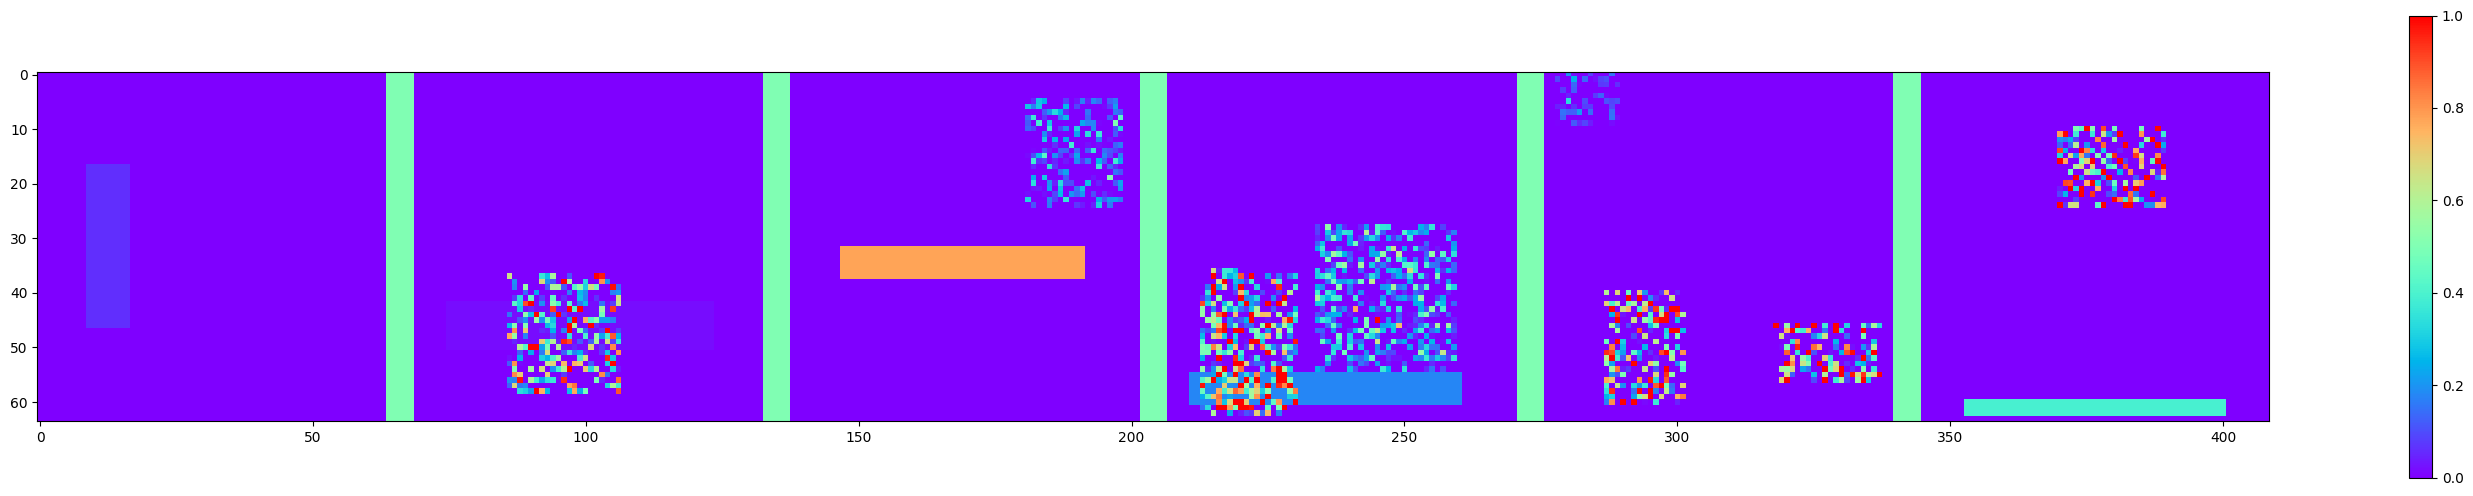

In [8]:
from utile import gen1_NES, gen2_NES
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Propose a learning strategy that leads to effective denoising.

The trick here is to create a new image from the noice we have

**Q2:** Discuss the limitations of the method and mention some avenues for improvement.

In [15]:
# 1. Define the model
fcn = UNet(1, 1, 16).cuda()  # Assuming UNet is defined in utile

# 2. Define the optimizer
optimizer = optim.Adam(fcn.parameters(), 1e-3)

# 3. Training loop
nepochs = 40
nbatches = 100
batchsize = 64
train_losses = []

for epoch in range(nepochs):
    print(f"Epoch {epoch + 1}/{nepochs}")
    epoch_losses = []
    for batch in range(nbatches):

        image2 = gen1_NES(batchsize)
        noise_images = gen2_NES(batchsize)
        image1 = image2 + noise_images

        input = image1.cuda()
        target = image2.cuda()

        optimizer.zero_grad()

        output = fcn(input)

        loss = F.mse_loss(output, target)

        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

Epoch 1/40
Epoch loss: 0.0196
Epoch 2/40
Epoch loss: 0.0147
Epoch 3/40
Epoch loss: 0.0140
Epoch 4/40
Epoch loss: 0.0139
Epoch 5/40
Epoch loss: 0.0139
Epoch 6/40
Epoch loss: 0.0137
Epoch 7/40
Epoch loss: 0.0137
Epoch 8/40
Epoch loss: 0.0138
Epoch 9/40
Epoch loss: 0.0138
Epoch 10/40
Epoch loss: 0.0135
Epoch 11/40
Epoch loss: 0.0135
Epoch 12/40
Epoch loss: 0.0135
Epoch 13/40
Epoch loss: 0.0136
Epoch 14/40
Epoch loss: 0.0134
Epoch 15/40
Epoch loss: 0.0135
Epoch 16/40
Epoch loss: 0.0139
Epoch 17/40
Epoch loss: 0.0135
Epoch 18/40
Epoch loss: 0.0135
Epoch 19/40
Epoch loss: 0.0138
Epoch 20/40
Epoch loss: 0.0134
Epoch 21/40
Epoch loss: 0.0135
Epoch 22/40
Epoch loss: 0.0135
Epoch 23/40
Epoch loss: 0.0135
Epoch 24/40
Epoch loss: 0.0135
Epoch 25/40
Epoch loss: 0.0137
Epoch 26/40
Epoch loss: 0.0134
Epoch 27/40
Epoch loss: 0.0136
Epoch 28/40
Epoch loss: 0.0135
Epoch 29/40
Epoch loss: 0.0134
Epoch 30/40
Epoch loss: 0.0134
Epoch 31/40
Epoch loss: 0.0135
Epoch 32/40
Epoch loss: 0.0131
Epoch 33/40
Epoch

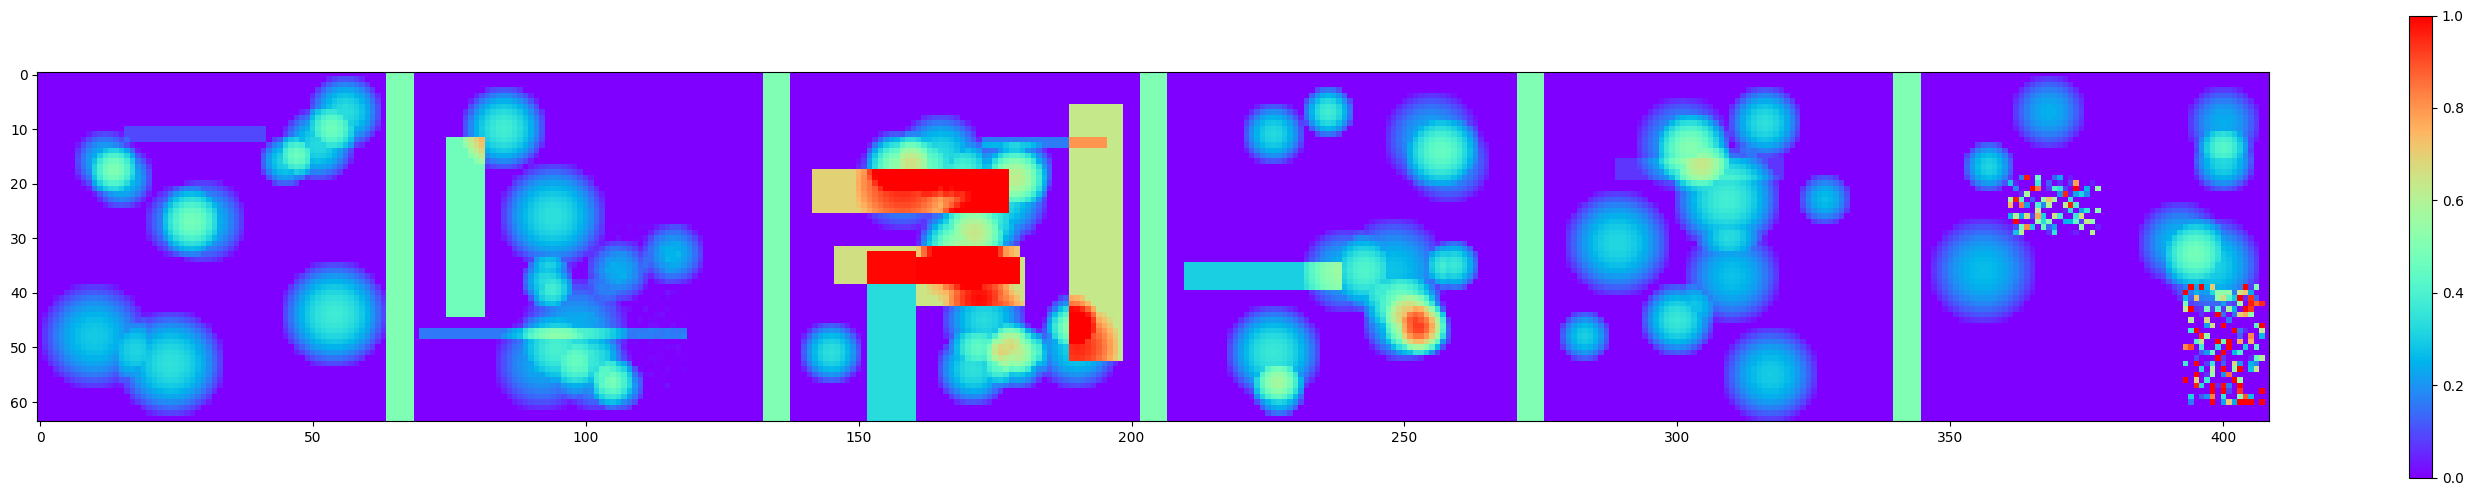

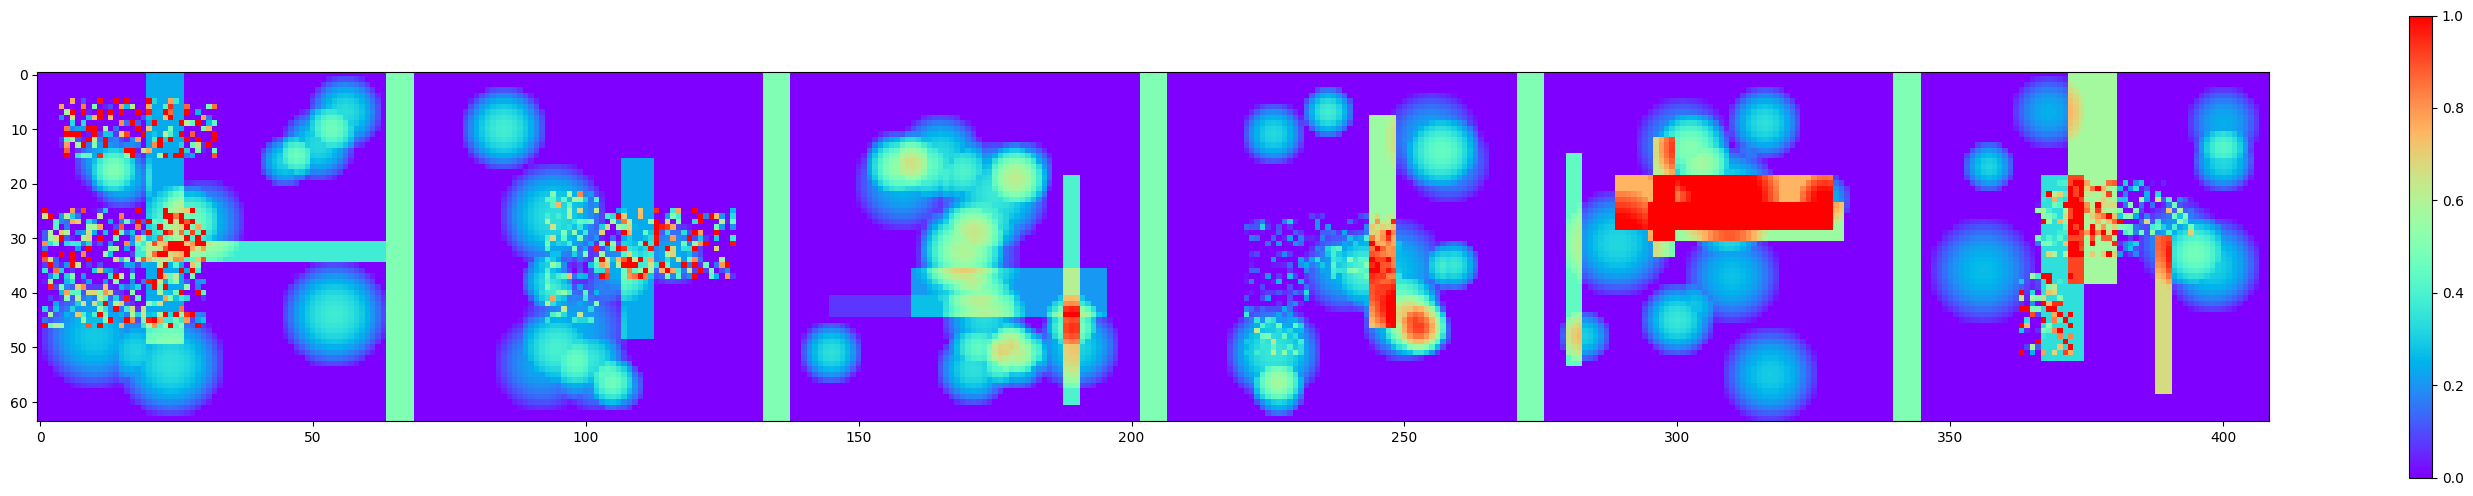

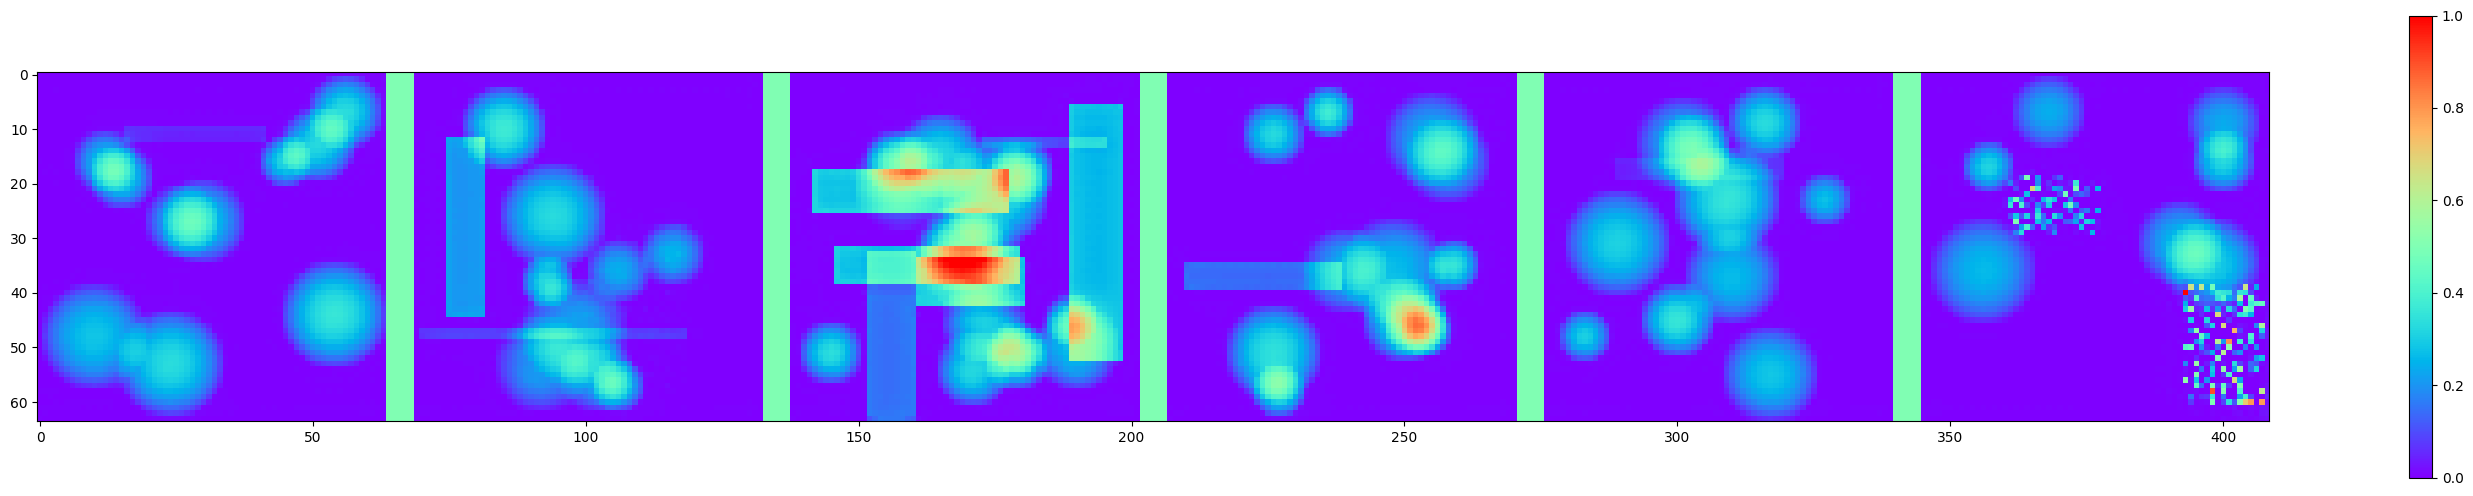

In [17]:
# viz:
fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs